In [1]:
import torch
import matplotlib.pyplot as plt
import torch
import torch
import torch
import re
import torch
from pathlib import Path
from dftorch.BondIntegral import bond_integral_vectorized
from dftorch.BondIntegral import LoadBondIntegralParameters, bond_integral_vectorized

import re
import torch
from pathlib import Path

def ScaleTail(A):
    A = A.clone()  # Ensure input isn't modified in-place

    if torch.abs(A[0]) < 1e-12:
        A[8:14] = 0.0  # A(9:14) in MATLAB (1-based) → A[8:14] in Python (0-based)
    else:
        R1 = A[6]
        RCUT = A[7]
        R1SQ = R1 * R1
        RMOD = R1 - A[5]
        POLYNOM = RMOD * (A[1] + RMOD * (A[2] + RMOD * (A[3] + A[4] * RMOD)))
        SCL_R1 = torch.exp(POLYNOM)
        DELTA = RCUT - R1

        # Fill in A(9:14) → A[8] to A[13]
        A[8] = SCL_R1

        DPOLY = A[1] + 2 * A[2] * RMOD + 3 * A[3] * RMOD ** 2 + 4 * A[4] * RMOD ** 3
        A[9] = DPOLY * SCL_R1

        DDPOLY = 2 * A[2] + 6 * A[3] * RMOD + 12 * A[4] * RMOD ** 2
        A[10] = (DPOLY ** 2 + DDPOLY) * SCL_R1 / 2

        DELTA2 = DELTA ** 2
        DELTA3 = DELTA2 * DELTA
        DELTA4 = DELTA3 * DELTA

        A[11] = (-1 / DELTA3) * (3 * A[10] * DELTA2 + 6 * A[9] * DELTA + 10 * A[8])
        A[12] = (1 / DELTA4) * (3 * A[10] * DELTA2 + 8 * A[9] * DELTA + 15 * A[8])
        A[13] = (-1 / (10 * DELTA3)) * (6 * A[12] * DELTA2 + 3 * A[11] * DELTA + A[10])

    return A

# =========================
# Reader: blocks like
#   A B channel
#   Npoints
#   R   S   H
# =========================
_HDR = re.compile(r'^\s*([A-Za-z][a-z]?)\s+([A-Za-z][a-z]?)\s+(\S+)\s*$')

def read_RSH_blocks(path: str):
    lines = Path(path).read_text(errors='ignore').splitlines()
    i, n = 0, len(lines)
    blocks = []

    def nxt(k):
        while k < n and (not lines[k].strip() or lines[k].lstrip().startswith(('#',';','!','%'))):
            k += 1
        return k

    while True:
        i = nxt(i)
        if i >= n: break
        m = _HDR.match(lines[i])
        if not m:
            i += 1
            continue
        Ael, Bel, ch = m.groups()
        i = nxt(i+1)
        if i >= n: break
        try:
            npts = int(lines[i].split()[0])
        except Exception as e:
            raise ValueError(f"Expected number of points after header '{Ael} {Bel} {ch}' at line {i+1}") from e
        i += 1

        R,S,H = [],[],[]
        read = 0
        while i < n and read < npts:
            ln = lines[i].strip(); i += 1
            if not ln or ln[0] in '#;!%': continue
            parts = ln.split()
            if len(parts) < 3: continue
            def fnum(x): return float(x.replace('D','E').replace('d','e'))
            R.append(fnum(parts[0])); S.append(fnum(parts[1])); H.append(fnum(parts[2])); read += 1
        if read != npts:
            raise ValueError(f"Block '{Ael} {Bel} {ch}': expected {npts} rows, got {read}")

        R = torch.tensor(R, dtype=torch.float64)
        order = torch.argsort(R)
        blocks.append({
            'elemA': Ael, 'elemB': Bel, 'channel': ch,
            'R': R[order],
            'S': torch.tensor(S, dtype=torch.float64)[order],
            'H': torch.tensor(H, dtype=torch.float64)[order],
            'npoints': npts,
        })
    if not blocks:
        raise ValueError(f"No blocks parsed from {path}")
    return blocks

def pick_block(path: str, elem_pair: tuple[str,str] | None, channel: str):
    bs = read_RSH_blocks(path)
    cand = [b for b in bs if b['channel'].lower()==channel.lower()
            and (elem_pair is None or (b['elemA'],b['elemB'])==elem_pair)]
    if not cand:
        raise ValueError(f"No block for channel='{channel}' and elem_pair={elem_pair}. "
                         f"Available: {[(b['elemA'],b['elemB'],b['channel']) for b in bs]}")
    return cand[0]

# =========================
# Tail from head (core X), pure functional (no in-place)
# =========================
def scale_tail(c1, c2, c3, c4, f5, R1, R2, eps=1e-12):
    RMOD  = R1 - f5
    POLY  = RMOD * (c1 + RMOD * (c2 + RMOD * (c3 + c4 * RMOD)))
    X1    = torch.exp(POLY)
    DP    = c1 + 2*c2*RMOD + 3*c3*RMOD**2 + 4*c4*RMOD**3
    DDP   = 2*c2 + 6*c3*RMOD + 12*c4*RMOD**2

    a = X1
    b = DP * X1
    c = (DP*DP + DDP) * X1 / 2

    DELTA  = torch.clamp(R2 - R1, min=torch.tensor(eps, dtype=R1.dtype, device=R1.device))
    DELTA2 = DELTA * DELTA
    DELTA3 = DELTA2 * DELTA
    DELTA4 = DELTA3 * DELTA

    d = -(3*c*DELTA2 + 6*b*DELTA + 10*a) / DELTA3
    e =  (3*c*DELTA2 + 8*b*DELTA + 15*a) / DELTA4
    g = -(6*e*DELTA2 + 3*d*DELTA + c) / (10*DELTA3)
    return torch.stack([a, b, c, d, e, g])  # (6,)

# =========================
# Piecewise evaluator (final value = f0 * Xcore)
# =========================
def eval_piecewise(R, f):
    f0, c1, c2, c3, c4, f5, R1, R2, a, b, c, d, e, g = f
    reg1 = (R > 1e-12) & (R <= R1)
    reg2 = (R > R1) & (R < R2)

    RMOD = R - f5
    poly = RMOD * (c1 + RMOD * (c2 + RMOD * (c3 + c4 * RMOD)))
    X1   = torch.exp(poly)

    t  = R - R1
    P  = a + t*(b + t*(c + t*(d + t*(e + t*g))))

    Xcore = reg1.to(R.dtype)*X1 + reg2.to(R.dtype)*P
    return f0 * Xcore

# =========================
# Minimal fitter for f0..f5; optional f6=R1 and f7=R2
# =========================
def fit_f_params(
    R, V,
    steps=800, lr=3e-2, l2=1e-10,
    fit_R1=False, fit_R2=False, fit_f5=True,   # <--- NEW FLAG
    f0_init=None, c1_init=None, c2_init=None, c3_init=None, c4_init=None, f5_init=None,
    R1_init=None, R2_init=None,
    dtype=torch.float64
):
    device = R.device
    R = R.to(dtype).contiguous()
    V = V.to(dtype).contiguous()

    Rmin, Rmax = float(R.min()), float(R.max())
    if R2_init is None: R2_init = Rmax
    if R1_init is None: R1_init = Rmin + 0.7*(Rmax - Rmin)

    # crude LS init on Region-1
    with torch.no_grad():
        m1 = R <= torch.tensor(R1_init, dtype=dtype, device=device)
        Rr, Vr = R[m1], V[m1]
        if Vr.numel() < 5:
            R1_init = Rmin + 0.8*(Rmax - Rmin)
            m1 = R <= torch.tensor(R1_init, dtype=dtype, device=device)
            Rr, Vr = R[m1], V[m1]
        if f5_init is None:
            f5_init = float(Rr[torch.argmax(Vr.abs())])
        Δ  = Rr - f5_init
        y  = torch.log(Vr.abs().clamp_min(1e-300))
        X  = torch.stack([torch.ones_like(Δ), Δ, Δ**2, Δ**3, Δ**4], dim=1)
        beta = torch.linalg.lstsq(X, y).solution
        a0, c1d, c2d, c3d, c4d = [float(b.item()) for b in beta]
        if f0_init is None:
            sgn = torch.sign(Vr.median())
            if sgn == 0:
                sgn = torch.sign(Vr[torch.argmax(Vr.abs())]) or torch.tensor(1.0, dtype=dtype)
            f0_init = float(torch.exp(torch.tensor(a0)).item()) * float(sgn.item())
        if c1_init is None: c1_init = c1d
        if c2_init is None: c2_init = c2d
        if c3_init is None: c3_init = c3d
        if c4_init is None: c4_init = c4d

    # trainables
    f0 = torch.nn.Parameter(torch.tensor(f0_init, dtype=dtype, device=device))
    c1 = torch.nn.Parameter(torch.tensor(c1_init, dtype=dtype, device=device))
    c2 = torch.nn.Parameter(torch.tensor(c2_init, dtype=dtype, device=device))
    c3 = torch.nn.Parameter(torch.tensor(c3_init, dtype=dtype, device=device))
    c4 = torch.nn.Parameter(torch.tensor(c4_init, dtype=dtype, device=device))
    if fit_f5:
        f5 = torch.nn.Parameter(torch.tensor(f5_init, dtype=dtype, device=device))
    else:
        f5 = torch.tensor(f5_init, dtype=dtype, device=device)  # fixed

    # R1/R2: fixed or fitted via safe reparam
    if fit_R1 or fit_R2:
        Rmin_t = torch.tensor(Rmin, dtype=dtype, device=device)
        span_t = torch.tensor(Rmax - Rmin, dtype=dtype, device=device)
        a_raw = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype, device=device))  # for R1
        b_raw = torch.nn.Parameter(torch.tensor(1.0, dtype=dtype, device=device))  # for gap to R2
        with torch.no_grad():
            a0 = (R1_init - Rmin) / max(Rmax - Rmin, 1e-6)
            a_raw.copy_(torch.log(torch.tensor(a0/(1-a0), dtype=dtype, device=device)))
            gap = max(R2_init - R1_init, 1e-3)
            b_raw.copy_(torch.log(torch.tensor(gap, dtype=dtype, device=device)))
        extra = [a_raw, b_raw]
    else:
        R1_fix = torch.tensor(R1_init, dtype=dtype, device=device)
        R2_fix = torch.tensor(R2_init, dtype=dtype, device=device)
        extra = []

    # optimizer includes f5 only if it's trainable
    params = [f0, c1, c2, c3, c4] + ( [f5] if fit_f5 else [] ) + extra
    opt = torch.optim.Adam(params, lr=lr)
    sch = torch.optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.5)

    losses = []
    for _ in range(steps):
        opt.zero_grad()

        if fit_R1 or fit_R2:
            R1 = Rmin_t + span_t * torch.sigmoid(a_raw) if fit_R1 else torch.tensor(R1_init, dtype=dtype, device=device)
            R2 = R1 + torch.nn.functional.softplus(b_raw) if fit_R2 else torch.tensor(R2_init, dtype=dtype, device=device)
        else:
            R1, R2 = R1_fix, R2_fix

        # tail from head (core X), assemble full f vector
        a,b,c_,d,e,g = scale_tail(c1,c2,c3,c4,f5,R1,R2)
        f_full = torch.stack([f0, c1, c2, c3, c4, f5, R1, R2, a, b, c_, d, e, g])

        # loss on whole region
        Yhat = eval_piecewise(R, f_full)
        loss = torch.mean((Yhat - V)**2) + l2*(f0*f0 + c1*c1 + c2*c2 + c3*c3 + c4*c4)
        loss.backward()
        opt.step()
        sch.step()

        losses.append(float(loss.detach().cpu().item()))
        if _%300 == 0:
            print(f"Step {_}: loss={losses[-1]:.6e}, f0={f0.item():.4e}, c1={c1.item():.4e}, c2={c2.item():.4e}, c3={c3.item():.4e}, c4={c4.item():.4e}, f5={f5.item():.4e}" +
                  (f", R1={R1.item():.4e}, R2={R2.item():.4e}" if (fit_R1 or fit_R2) else ""))

    with torch.no_grad():
        if fit_R1 or fit_R2:
            R1 = Rmin_t + span_t * torch.sigmoid(a_raw) if fit_R1 else torch.tensor(R1_init, dtype=dtype, device=device)
            R2 = R1 + torch.nn.functional.softplus(b_raw) if fit_R2 else torch.tensor(R2_init, dtype=dtype, device=device)
        a,b,c_,d,e,g = scale_tail(c1.detach(),c2.detach(),c3.detach(),c4.detach(),f5.detach(),R1, R2)
        f_final = torch.stack([f0.detach(), c1.detach(), c2.detach(), c3.detach(), c4.detach(),
                               f5.detach(), R1.detach(), R2.detach(), a, b, c_, d, e, g])
    return f_final, losses

# =========================
# Convenience: from file
# =========================


def fit_f_params_LBFGS(
    R, V, lr,
    steps=500, l2=1e-10,
    fit_R1=False, fit_R2=False, fit_f5=True,
    f0_init=None, c1_init=None, c2_init=None, c3_init=None, c4_init=None, f5_init=None,
    R1_init=None, R2_init=None,
    dtype=torch.float64,
    margin=0.2   # <-- enforce at least this much spacing between R1 and R2
):
    device = R.device
    R = R.to(dtype).contiguous()
    V = V.to(dtype).contiguous()

    Rmin, Rmax = float(R.min()), float(R.max())
    if R2_init is None: R2_init = Rmax
    if R1_init is None: R1_init = Rmin + 0.7*(Rmax - Rmin)

    # ----- init -----
    with torch.no_grad():
        m1 = R <= torch.tensor(R1_init, dtype=dtype, device=device)
        Rr, Vr = R[m1], V[m1]
        if f5_init is None and Rr.numel() > 0:
            f5_init = float(Rr[torch.argmax(Vr.abs())])
        if f5_init is None:
            f5_init = 0.5*(Rmin+Rmax)

    # trainables
    f0 = torch.nn.Parameter(torch.tensor(f0_init if f0_init is not None else 1.0, dtype=dtype, device=device))
    c1 = torch.nn.Parameter(torch.tensor(c1_init if c1_init is not None else -1.0, dtype=dtype, device=device))
    c2 = torch.nn.Parameter(torch.tensor(c2_init if c2_init is not None else 0.0, dtype=dtype, device=device))
    c3 = torch.nn.Parameter(torch.tensor(c3_init if c3_init is not None else 0.0, dtype=dtype, device=device))
    c4 = torch.nn.Parameter(torch.tensor(c4_init if c4_init is not None else 0.0, dtype=dtype, device=device))
    f5 = torch.nn.Parameter(torch.tensor(f5_init, dtype=dtype, device=device)) if fit_f5 else torch.tensor(f5_init, dtype=dtype, device=device)

    # R1/R2 handling
    R1_fix = torch.tensor(R1_init, dtype=dtype, device=device)
    R2_fix = torch.tensor(R2_init, dtype=dtype, device=device)
    extra = []

    if fit_R1:
        Rmin_t = torch.tensor(Rmin, dtype=dtype, device=device)
        span_t = torch.tensor(Rmax - Rmin, dtype=dtype, device=device)
        a_raw = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype, device=device))
        with torch.no_grad():
            a0 = (R1_init - Rmin) / max(Rmax - Rmin, 1e-6)
            a_raw.copy_(torch.log(torch.tensor(a0/(1-a0), dtype=dtype, device=device)))
        extra.append(a_raw)
    else:
        a_raw = None

    if fit_R2:
        b_raw = torch.nn.Parameter(torch.tensor(1.0, dtype=dtype, device=device))
        with torch.no_grad():
            gap = max(R2_init - R1_init, 1e-3)
            b_raw.copy_(torch.log(torch.tensor(gap, dtype=dtype, device=device)))
        extra.append(b_raw)
    else:
        b_raw = None

    # optimizer
    params = [f0, c1, c2, c3, c4] + ([f5] if fit_f5 else []) + extra
    print(lr)
    opt = torch.optim.LBFGS(params, lr=lr, max_iter=20, line_search_fn="strong_wolfe")

    losses = []

    def closure():
        opt.zero_grad()

        # R1
        if fit_R1:
            R1 = Rmin_t + span_t * torch.sigmoid(a_raw)
        else:
            R1 = R1_fix

        # R2
        if fit_R2:
            R2 = R1 + torch.nn.functional.softplus(b_raw)
        else:
            R2 = R2_fix

        # clamp R1 if only R1 is fitted
        if fit_R1 and not fit_R2:
            R1 = torch.clamp(R1, max=R2 - margin)

        # tail + loss
        a,b,c_,d,e,g = scale_tail(c1,c2,c3,c4,f5,R1,R2)
        f_full = torch.stack([f0, c1, c2, c3, c4, f5, R1, R2, a, b, c_, d, e, g])
        Yhat = eval_piecewise(R, f_full)
        loss = torch.mean((Yhat - V)**2) + l2*(f0*f0 + c1*c1 + c2*c2 + c3*c3 + c4*c4)
        loss.backward()
        return loss

    for i in range(steps):
        loss = opt.step(closure)
        losses.append(float(loss.detach().cpu().item()))
        if i % 50 == 0:
            print(f"LBFGS step {i}: loss={losses[-1]:.4e}")

    with torch.no_grad():
        if fit_R1:
            R1 = Rmin_t + span_t * torch.sigmoid(a_raw)
        else:
            R1 = R1_fix
        if fit_R2:
            R2 = R1 + torch.nn.functional.softplus(b_raw)
        else:
            R2 = R2_fix
        if fit_R1 and not fit_R2:
            R1 = torch.clamp(R1, max=R2 - margin)

        a,b,c_,d,e,g = scale_tail(c1.detach(),c2.detach(),c3.detach(),c4.detach(),
                                  f5.detach() if fit_f5 else f5, R1, R2)
        f_final = torch.stack([f0.detach(), c1.detach(), c2.detach(), c3.detach(), c4.detach(),
                               f5.detach() if fit_f5 else f5, R1.detach(), R2.detach(),
                               a,b,c_,d,e,g])
    return f_final, losses



def fit_from_file(path: str, elem_pair: tuple[str,str] | None, channel: str, which='H', lower_bound=None, **fit_kwargs):
    blk = pick_block(path, elem_pair, channel)
    R = blk['R'][lower_bound:]
    V = blk['H'][lower_bound:] if which.upper()=='H' else blk['S'][lower_bound:]
    return *fit_f_params_LBFGS(R, V, **fit_kwargs), blk

In [180]:
lower_bound = 75
f, losses, meta = fit_from_file("sk/bondints.table", ("Ni","Ni"), "pdp", which="H",
                           steps=300, fit_R1=False, fit_R2=False, fit_f5=True,
                           R1_init=1.0, R2_init=3.5, f5_init=2.5, 
                           f0_init=None,
                           c1_init=-8.0,
                        #    c2_init=8.0,
                        #    c3_init=-1,
                        #    c4_init=-7,
                           lower_bound=lower_bound,
                           lr=2e-5,
                           l2=1e-10)

2e-05
LBFGS step 0: loss=8.1122e+10
LBFGS step 50: loss=5.2336e-01
LBFGS step 100: loss=4.6108e-01
LBFGS step 150: loss=4.5801e-01
LBFGS step 200: loss=4.5793e-01
LBFGS step 250: loss=4.5793e-01


tensor(-2.6988, dtype=torch.float64)
tensor(-0.6774, dtype=torch.float64)


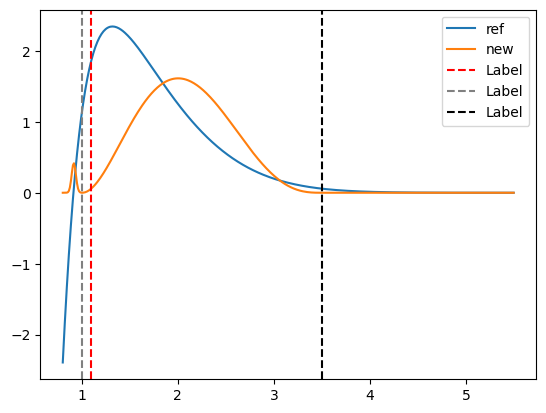

In [181]:
out_new = bond_integral_vectorized(meta['R'],f.repeat(len(meta['R']),1))
plt.plot(meta['R'][lower_bound:], meta['H'][lower_bound:], label='ref')
plt.plot(meta['R'][lower_bound:], out_new[lower_bound:], label='new')
print(meta['R'][lower_bound:][torch.argmin(meta['H'][lower_bound:])] - meta['R'][lower_bound:][torch.argmin(out_new[lower_bound:])])
print(meta['R'][lower_bound:][torch.argmax(meta['H'][lower_bound:])] - meta['R'][lower_bound:][torch.argmax(out_new[lower_bound:])])

plt.axvline(x=f[5], color='red', linestyle='--', label='Label')
plt.axvline(x=f[6], color='gray', linestyle='--', label='Label')
plt.axvline(x=f[7], color='black', linestyle='--', label='Label')
plt.legend()
plt.show()

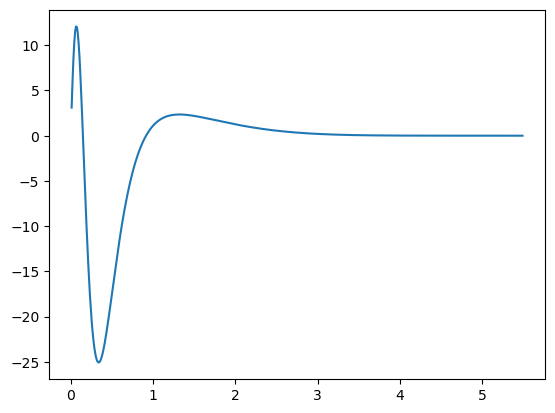

In [150]:
low = 0
plt.plot(meta['R'][low:], meta['H'][low:], label='ref')
plt.show()

In [58]:
with torch.no_grad():
    torch.set_printoptions(sci_mode=False)
    print(f)

tensor([     0.0000,   -145.8833,   -183.7820,    178.3267,    -86.3729,
             1.2000,      0.8937,      4.5000, 2299835142.5329, 61735574083.0627,
        -82804657562.1819, 39911388143.7725, -8366551077.4934, 647889556.4834],
       dtype=torch.float64)


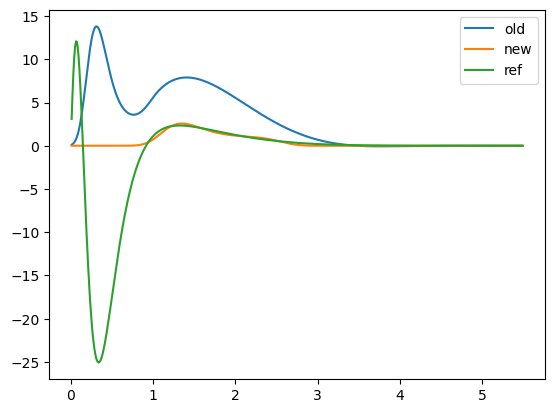

In [76]:
from dftorch.BondIntegral import LoadBondIntegralParameters, bond_integral_vectorized

fss = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,28]), '../src/dftorch/params/fsp_sigma.csv').to(torch.float64)
out_old = bond_integral_vectorized(meta['R'], fss.repeat(len(meta['R']),1))
out_new = bond_integral_vectorized(meta['R'],f.repeat(len(meta['R']),1))

plt.plot(meta['R'], out_old, label='old')
plt.plot(meta['R'], out_new, label='new')
plt.plot(meta['R'], meta['H'], label='ref')
plt.legend()
plt.show()

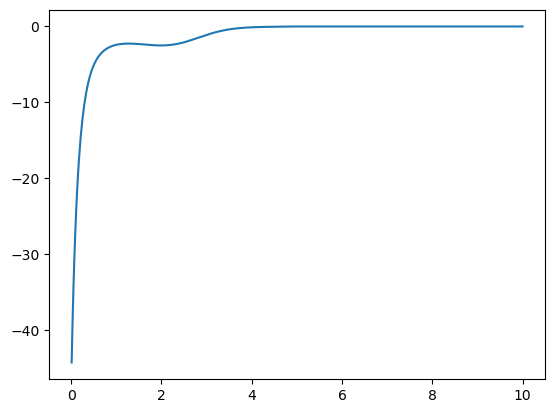

In [ ]:
import numpy as np
x = np.linspace(0.01,10,500)
R = torch.tensor(x, dtype=torch.double)
out = bond_integral_vectorized(R,f_cc_ppsigma.repeat(500,1))
plt.plot(x, out.cpu())

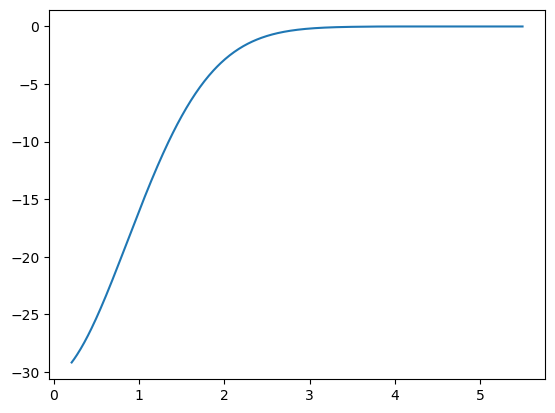

In [ ]:
from dftorch.BondIntegral import LoadBondIntegralParameters, bond_integral_vectorized
fss = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,6]), '../src/dftorch/params/fss_sigma.csv')
out = bond_integral_vectorized(torch.tensor(x, dtype=torch.float32),fss.repeat(500,1))
plt.plot(x, out.cpu())

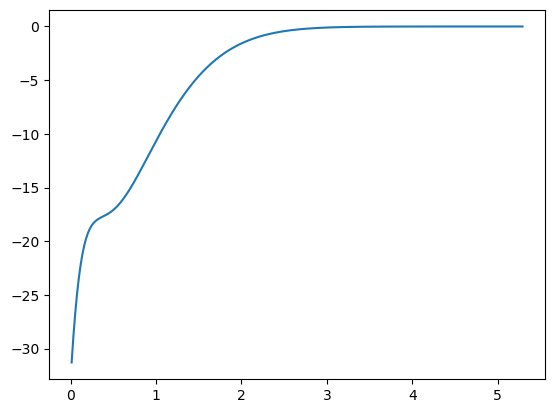

In [ ]:
plt.plot(x, C_C_ss*27.2114, label='data')